In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from gymnasium import spaces
import gym_anytrading
import gym_trading_env
import random
# import tensorflow as tf
# from tensorflow.keras import layers, models, optimizers
from collections import deque
from stable_baselines3 import PPO
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.callbacks import StopTrainingOnRewardThreshold
from sklearn.preprocessing import StandardScaler



In [2]:
df = pd.read_csv('data\crypto_with_indicators.csv')
df.head()

,Open Time,BTCUSDT_Close,BTCUSDT_Volume,ETHUSDT_Close,ETHUSDT_Volume,XRPUSDT_Close,XRPUSDT_Volume,SOLUSDT_Close,SOLUSDT_Volume,BNBUSDT_Close,...,RENDERUSDT_Close,RENDERUSDT_Volume,JUPUSDT_Close,JUPUSDT_Volume,FILUSDT_Close,FILUSDT_Volume,ARBUSDT_Close,ARBUSDT_Volume,FDUSDUSDT_Close,FDUSDUSDT_Volume
0,2020-03-25 00:00:00,6557.75,17042.837312,136.09,184453.53893,0.16024,34368839.9,NaN,NaN,12.1749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-25 04:00:00,6675.21,12406.070557,138.27,122363.50920,0.16226,24748020.1,NaN,NaN,12.4163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-25 08:00:00,6521.36,45370.620679,134.37,343216.98456,0.15810,64665116.6,NaN,NaN,12.1400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-25 12:00:00,6617.27,30706.295240,135.47,196526.13761,0.15938,41978907.8,NaN,NaN,12.2659,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-25 16:00:00,6622.38,14683.351661,135.77,92691.18497,0.16026,18471806.2,NaN,NaN,12.2300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df = df.rename(columns={'Open Time':'Date'})

In [4]:
df = df.set_index('Date')

In [5]:
scaler = StandardScaler()

In [6]:
df_scaled = scaler.fit_transform(df)

In [7]:
df_scaled

array([[-1.44569733,  0.18127225, -1.77242775, ...,         nan,
                nan,         nan],
       [-1.44047559, -0.08688347, -1.77045336, ...,         nan,
                nan,         nan],
       [-1.44731507,  1.81953815, -1.77398552, ...,         nan,
                nan,         nan],
       ...,
       [ 2.48785885, -0.52186082,  0.44975968, ..., -0.24473386,
        -0.59396635, -0.25666035],
       [ 2.52063942, -0.61914177,  0.46143391, ..., -0.53039097,
        -0.59396635, -0.26083127],
       [ 2.49934836, -0.66513591,  0.44753171, ..., -0.38385407,
        -0.59396635, -0.07417872]])

In [8]:
((df-df.mean())/df.std()).bfill(axis=0).head()

,BTCUSDT_Close,BTCUSDT_Volume,ETHUSDT_Close,ETHUSDT_Volume,XRPUSDT_Close,XRPUSDT_Volume,SOLUSDT_Close,SOLUSDT_Volume,BNBUSDT_Close,BNBUSDT_Volume,...,RENDERUSDT_Close,RENDERUSDT_Volume,JUPUSDT_Close,JUPUSDT_Volume,FILUSDT_Close,FILUSDT_Volume,ARBUSDT_Close,ARBUSDT_Volume,FDUSDUSDT_Close,FDUSDUSDT_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-25 00:00:00,-1.445630,0.181264,-1.772345,0.810504,-0.992433,-0.426700,-1.053801,-0.926447,-1.620845,0.859526,...,0.385196,1.351997,-1.306215,20.226494,1.119444,-0.514307,0.633829,9.723731,0.218453,-0.759262
2020-03-25 04:00:00,-1.440408,-0.086879,-1.770371,0.169583,-0.988285,-0.519227,-1.053801,-0.926447,-1.619609,2.397132,...,0.385196,1.351997,-1.306215,20.226494,1.119444,-0.514307,0.633829,9.723731,0.218453,-0.759262
2020-03-25 08:00:00,-1.447248,1.819453,-1.773903,2.449332,-0.996828,-0.135326,-1.053801,-0.926447,-1.621024,2.397456,...,0.385196,1.351997,-1.306215,20.226494,1.119444,-0.514307,0.633829,9.723731,0.218453,-0.759262
2020-03-25 12:00:00,-1.442984,0.971419,-1.772907,0.935123,-0.994199,-0.353510,-1.053801,-0.926447,-1.620379,0.733323,...,0.385196,1.351997,-1.306215,20.226494,1.119444,-0.514307,0.633829,9.723731,0.218453,-0.759262
2020-03-25 16:00:00,-1.442757,0.044815,-1.772635,-0.136708,-0.992392,-0.579589,-1.053801,-0.926447,-1.620563,0.309534,...,0.385196,1.351997,-1.306215,20.226494,1.119444,-0.514307,0.633829,9.723731,0.218453,-0.759262


In [9]:
companies = list(df.columns)
companies,signals = ((list(set(map(lambda x: x.split('_')[0], companies[1:])))),
                    (list(set(map(lambda x: x.split('_')[1], companies[1:])))))

print(companies,'\n',signals)

['POLUSDT', 'RENDERUSDT', 'BTCUSDT', 'SOLUSDT', 'DOTUSDT', 'XLMUSDT', 'ETHUSDT', 'DOGEUSDT', 'SHIBUSDT', 'ICPUSDT', 'APTUSDT', 'TONUSDT', 'ADAUSDT', 'XRPUSDT', 'ETCUSDT', 'OMUSDT', 'PEPEUSDT', 'LTCUSDT', 'ARBUSDT', 'LINKUSDT', 'HBARUSDT', 'AVAXUSDT', 'AAVEUSDT', 'ALGOUSDT', 'TRXUSDT', 'TAOUSDT', 'VETUSDT', 'TRUMPUSDT', 'SUIUSDT', 'FILUSDT', 'BCHUSDT', 'FDUSDUSDT', 'JUPUSDT', 'BNBUSDT', 'UNIUSDT', 'NEARUSDT', 'USDCUSDT'] 
 ['Close', 'Volume']


In [10]:
len(companies)

37

In [11]:
Company_dict = {}
for crypto in companies:
    Company_dict[f'df_{crypto}'] = pd.DataFrame()
    for column in df.columns[:]:
        if str(column).split('_')[0] != crypto:
            continue
        else:
            Company_dict[f'df_{crypto}'] = pd.concat([Company_dict[f'df_{crypto}'], df[column] ], axis=1)


In [12]:
locals().update(Company_dict)

In [13]:
df_BTCUSDT

,BTCUSDT_Close,BTCUSDT_Volume
2020-03-25 00:00:00,6557.75,17042.837312
2020-03-25 04:00:00,6675.21,12406.070557
2020-03-25 08:00:00,6521.36,45370.620679
2020-03-25 12:00:00,6617.27,30706.295240
2020-03-25 16:00:00,6622.38,14683.351661
...,...,...
2025-02-11 08:00:00,98151.52,1703.700260
2025-02-11 12:00:00,97007.53,4245.102450
2025-02-11 16:00:00,95040.82,4884.737110
2025-02-11 20:00:00,95778.20,3202.620870


In [14]:
# for i in list(Company_dict.keys()):
#     if i in locals():
#         del locals()[i]

In [15]:
# # Load historical data (replace 'crypto_data.csv' with your dataset)
# data = df_BTCUSDT
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

# # Normalize the data (e.g., price, volume, etc.)
# def normalize_data(df):
#     return (df - df.mean()) / df.std()

# data = normalize_data(data)

# # Split data into training and testing sets
# train_data = data[data.index.year <= 2023]
# test_data = data[data.index.year > 2023]

In [16]:
# class CryptoTradingEnv:
#     def __init__(self, data, initial_balance=1000):
#         self.data = data
#         self.initial_balance = initial_balance
#         self.reset()

#     def reset(self):
#         self.balance = self.initial_balance
#         self.net_worth = self.initial_balance
#         self.current_step = 0
#         self.done = False
#         return self._get_state()

#     def _get_state(self):
#         # Return the current state (e.g., price, volume, etc.)
#         return self.data.iloc[self.current_step].values

#     def step(self, action):
#         # Actions: 0 = Hold, 1 = Buy, 2 = Sell
#         current_price = self.data.iloc[self.current_step]['BTCUSDT_Close']
#         reward = 0

#         if action == 1:  # Buy
#             self.balance -= current_price
#         elif action == 2:  # Sell
#             self.balance += current_price

#         # Update net worth
#         self.net_worth = self.balance
#         reward = self.net_worth - self.initial_balance

#         # Check if episode is done
#         self.current_step += 1
#         if self.current_step >= len(self.data) - 1 or self.net_worth <= 0:
#             self.done = True

#         return self._get_state(), reward, self.done, {}

# # Create training and testing environments
# train_env = CryptoTradingEnv(train_data)
# test_env = CryptoTradingEnv(test_data)

In [17]:
# class PPOAgent:
#     def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, clip_ratio=0.2):
#         self.state_dim = state_dim
#         self.action_dim = action_dim
#         self.gamma = gamma
#         self.clip_ratio = clip_ratio

#         # Actor and Critic networks
#         self.actor = self._build_actor()
#         self.critic = self._build_critic()
#         self.actor_optimizer = optimizers.Adam(learning_rate=lr)
#         self.critic_optimizer = optimizers.Adam(learning_rate=lr)

#     def _build_actor(self):
#         inputs = layers.Input(shape=(self.state_dim,))
#         x = layers.Dense(64, activation='relu')(inputs)
#         x = layers.Dense(64, activation='relu')(x)
#         outputs = layers.Dense(self.action_dim, activation='softmax')(x)
#         return models.Model(inputs, outputs)

#     def _build_critic(self):
#         inputs = layers.Input(shape=(self.state_dim,))
#         x = layers.Dense(64, activation='relu')(inputs)
#         x = layers.Dense(64, activation='relu')(x)
#         outputs = layers.Dense(1)(x)
#         return models.Model(inputs, outputs)

#     def get_action(self, state):
#         state = np.expand_dims(state, axis=0)
#         probs = self.actor.predict(state)
#         action = np.random.choice(self.action_dim, p=probs[0])
#         return action

#     def train(self, states, actions, rewards, next_states, dones):
#         states = np.array(states)
#         actions = np.array(actions)
#         rewards = np.array(rewards)
#         next_states = np.array(next_states)
#         dones = np.array(dones)

#         # Compute advantages and returns
#         values = self.critic.predict(states)
#         next_values = self.critic.predict(next_states)
#         advantages = rewards + self.gamma * next_values * (1 - dones) - values
#         returns = advantages + values

#         # Update actor
#         with tf.GradientTape() as tape:
#             probs = self.actor(states)
#             action_probs = tf.reduce_sum(probs * tf.one_hot(actions, self.action_dim), axis=1)
#             old_probs = tf.stop_gradient(action_probs)
#             ratio = action_probs / old_probs
#             clipped_ratio = tf.clip_by_value(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio)
#             actor_loss = -tf.reduce_mean(tf.minimum(ratio * advantages, clipped_ratio * advantages))
#         actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
#         self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))

#         # Update critic
#         with tf.GradientTape() as tape:
#             critic_loss = tf.reduce_mean(tf.square(returns - self.critic(states)))
#         critic_grads = tape.gradient(critic_loss, self.critic.trainable_variables)
#         self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))

In [18]:
# state_dim = train_env.data.shape[1]
# action_dim = 3  # Hold, Buy, Sell
# agent = PPOAgent(state_dim, action_dim)

# episodes = 100
# for episode in range(episodes):
#     state = train_env.reset()
#     done = False
#     total_reward = 0

#     while not done:
#         action = agent.get_action(state)
#         next_state, reward, done, _ = train_env.step(action)
#         agent.train([state], [action], [reward], [next_state], [done])
#         state = next_state
#         total_reward += reward

#     print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

In [19]:
# state = test_env.reset()
# done = False
# total_reward = 0

# while not done:
#     action = agent.get_action(state)
#     next_state, reward, done, _ = test_env.step(action)
#     state = next_state
#     total_reward += reward

# print(f"Test Total Reward: {total_reward}")

In [20]:
# plt.plot(test_env.net_worth_history)
# plt.xlabel('Time Steps')
# plt.ylabel('Net Worth')
# plt.title('Net Worth Over Time')
# plt.show()

Add Indicators

In [21]:
print(dict(zip(Company_dict.keys(),companies)))

{'df_POLUSDT': 'POLUSDT', 'df_RENDERUSDT': 'RENDERUSDT', 'df_BTCUSDT': 'BTCUSDT', 'df_SOLUSDT': 'SOLUSDT', 'df_DOTUSDT': 'DOTUSDT', 'df_XLMUSDT': 'XLMUSDT', 'df_ETHUSDT': 'ETHUSDT', 'df_DOGEUSDT': 'DOGEUSDT', 'df_SHIBUSDT': 'SHIBUSDT', 'df_ICPUSDT': 'ICPUSDT', 'df_APTUSDT': 'APTUSDT', 'df_TONUSDT': 'TONUSDT', 'df_ADAUSDT': 'ADAUSDT', 'df_XRPUSDT': 'XRPUSDT', 'df_ETCUSDT': 'ETCUSDT', 'df_OMUSDT': 'OMUSDT', 'df_PEPEUSDT': 'PEPEUSDT', 'df_LTCUSDT': 'LTCUSDT', 'df_ARBUSDT': 'ARBUSDT', 'df_LINKUSDT': 'LINKUSDT', 'df_HBARUSDT': 'HBARUSDT', 'df_AVAXUSDT': 'AVAXUSDT', 'df_AAVEUSDT': 'AAVEUSDT', 'df_ALGOUSDT': 'ALGOUSDT', 'df_TRXUSDT': 'TRXUSDT', 'df_TAOUSDT': 'TAOUSDT', 'df_VETUSDT': 'VETUSDT', 'df_TRUMPUSDT': 'TRUMPUSDT', 'df_SUIUSDT': 'SUIUSDT', 'df_FILUSDT': 'FILUSDT', 'df_BCHUSDT': 'BCHUSDT', 'df_FDUSDUSDT': 'FDUSDUSDT', 'df_JUPUSDT': 'JUPUSDT', 'df_BNBUSDT': 'BNBUSDT', 'df_UNIUSDT': 'UNIUSDT', 'df_NEARUSDT': 'NEARUSDT', 'df_USDCUSDT': 'USDCUSDT'}


In [22]:
#SB3
# Load historical data
data = df


# Normalize or preprocess data (e.g., calculate returns, moving averages, etc.)
data = (data - data.mean())/data.std()

# for company,asset in dict(zip(list(Company_dict.keys),companies)):
#     company[f'{asset}_Returns'] = df[f'{asset}_Close'].pct_change()


data.bfill(inplace=True)

In [ ]:
data

In [24]:
len(df.columns)//2

37

In [ ]:
# Split data into training and testing sets
train_data_norm = data.iloc[:int(0.8 * len(data))]  # First 80% for training
test_data_norm = data.iloc[int(0.8 * len(data)):]   # Last 20% for testing 

In [26]:
scale=0.05 # buy/sell signals on 5% of the data


In [27]:
current_prices = df.iloc[0][::2]


In [28]:
y = dict(enumerate(current_prices))

In [29]:
y[7]

0.02943

In [ ]:
class CryptoTradingEnv(gym.Env):
    def __init__(self, data, initial_balance = 100000, window_size = 6, memory_size = 100):
        super(CryptoTradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.current_step = window_size
        self.window_size = window_size
        if self.window_size < 1:    
            raise ValueError('Window must be greater than 1')
        self.action_history = []
        self.account_net_worth_history = [initial_balance]
        self.account_balance_history = deque([initial_balance],maxlen=self.window_size)
        self.num_tokens = len(self.data.columns)//2
        self.crypto_held = np.zeros(shape=(1,self.num_tokens),dtype=int)
        # self.memory_size = memory_size

        # Define action space: positions 0 = Hold, 1 = Buy(Long), 2 = Sell(Short) & none = 0, small = 1,large = 2
        
        self.action_space = spaces.MultiDiscrete([3,3]*self.num_tokens)
        # Define observation space (e.g., returns, moving averages, etc.)
        self.observation_space = spaces.Box(low=-np.inf,
                                            high=np.inf, 
                                            shape=(1,self.window_size*len(self.data)+3+self.num_tokens), 
                                            dtype=np.float32)

        self.reset()

    def reset(self, seed=None, options=None):
        # Initialize the environment state
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.crypto_held = np.zeros(shape=(1,self.num_tokens),dtype=int)
        self.current_step = self.window_size
        # Reset memory
        # self.memory.clear()
        # self.memory = deque(np.zeros(self.window_size),maxlen=self.memory_size)

        
        return self._get_observation(), {}  # Return observation and info dict

    def _get_observation(self):
        # Return current state (returns, close vol,)        
        window = self.data.iloc[self.current_step-self.window_size : self.current_step]
        obs = window
        
        # update with better indicators *update observation space)
        portfolio_state= np.array([
            self.balance / self.initial_balance,  # Normalized balance            
            self.net_worth / self.initial_balance,  # Normalized net worth
            self.current_step / len(self.data)    #percentage of data seen *for lr scheduler
        ])

        portfolio_state = portfolio_state.reshape(1,-1)        
         
        
        obs = np.append(obs,portfolio_state)
        obs = np.append(obs,self.crypto_held)

        
        # # Add memory (past actions) to the observation
        # memory_array = np.array(self.memory, dtype=np.float32)
        # obs = obs.to_dict()
        # obs['memory'] = memory_array
        # obs = obs.values()

        return obs

    def step(self, action):
        if self.current_step >= len(self.data) - 1:
            raise ValueError("Episode is done. Call reset() to start a new episode.")
        
        # Append action to action history 
        # self.action_history.append(action)
        # self.memory.append(action)

        # Take action
        current_prices = self.data.iloc[self.current_step][::2]
        self._take_action(action, current_prices)
        self.current_step += 1

        # Calculate reward 
        #(net worth > previous net worth)
        reward = (self.net_worth - self.account_net_worth_history[-2]) / self.initial_balance
        
        #(Alternate net worth/previous net worth - heavily penalizes loss)
        # reward = np.log(self.net_worth/self.account_net_worth_history[-2])

        # Add risk penalty - *remember add ma, obv, pascal sar 
        drawdown = (self.initial_balance - self.net_worth) / self.initial_balance
        risk_penalty = -10 * max(0, drawdown)
        reward += risk_penalty
        
        # Add trading penalty - *remember add transaction fees
        # trading_penalty = -0.1 * abs(action)
        # reward += trading_penalty

        # Check if done
        done = self.current_step >= len(self.data) - 1 or self.net_worth <= 0.5 * self.initial_balance

        #Add final reward to encourage learning
        if done:
            final_return = (self.net_worth - self.initial_balance) / self.initial_balance
            reward += final_return

        # Return observation, reward, done, truncated, and info
        return self._get_observation(), reward, done, False, {}

    def _buy_token(self, token_price, size, index):
        if self.balance > self.balance//size :
            cost = self.balance // size
            self.crypto_held[0][index] += int(cost //token_price)
            self.balance -= cost
        else:
            pass

    def _sell_token(self, token_price, size, index):       
        if int(self.crypto_held[0][index] // size) >= 1:
            revenue = self.crypto_held[0][index] // size * token_price
            self.balance += revenue
            self.crypto_held[0][index] -= int(self.crypto_held[0][index] // size)
        else:
            pass
    
    def _take_action(self, action, current_prices):
        # Take action for each token
        for i,token_price in enumerate(current_prices):
            action_type = action[i]  # 0 = Hold, 1 = Buy, 2 = Sell
            position_size = action[i + 1]  # 0 = None, 1 = Small, 2 = Large

            if action_type == 1:  # Buy
                if position_size == 1:  # Small
                    self._buy_token(token_price, size=10,index= i)  # Buy 10% of available balance
                elif position_size == 2:  # Large
                    self._buy_token(token_price, size=2,index = i)  # Buy 50% of available balance
            elif action_type == 2:  # Sell
                if position_size == 1:  # Small
                    self._sell_token(token_price, size=10,index = i)  # Sell 10% of holdings
                elif position_size == 2:  # Large
                    self._sell_token(token_price, size=2,index = i)  # Sell 50% of holdings
            
            elif action_type == 0:  # Hold
                pass

        # Update net worth
        self.net_worth = self.balance + (self.crypto_held[0] * current_prices.values).sum()
        self.account_net_worth_history.append(self.net_worth)

    def render(self, mode='human'):
        if mode == 'human':
            plt.figure(figsize=(10, 5))
            sns.set_style("whitegrid")
            
            # Plot buy/sell signals
            # s = round(scale*(len(self.data)))
            # buy_steps = [i for i, a in enumerate(self.action_history) if a == 1]
            # sell_steps = [i for i, a in enumerate(self.action_history) if a == 2]
            # plt.scatter(buy_steps[::s], [self.account_net_worth_history.iloc[i] for i in buy_steps][::s], 
            #             label='Buy', color='green', marker='^', alpha=1)
            # plt.scatter(sell_steps[::s], [self.acount_networt_history.iloc[i] for i in sell_steps][::s], 
            #         label='Sell', color='red', marker='v', alpha=1)
            
            # Portfolio value
            plt.plot(self.account_net_worth_history, label='Portfolio Value', color='grey')
            
            # token price
            data_USD = data*df.std()+df.mean()
            token_prices = data_USD.iloc[ : , ::2]
            plt.plot(token_prices, alpha=0.5) #label = list(token_prices.columns)

            
            plt.xticks(range(0, len(self.data), len(self.data) // 10), 
                       pd.to_datetime(self.data.index).strftime('%Y-%m-%d').values[::len(self.data) // 10],
                       rotation=45
                       )
            plt.title('Portfolio Valuation Over Time')
            plt.xlabel('Time Step')
            plt.ylabel('Net Worth (USD)')
            plt.legend()
            plt.show()
            pass
        print(f'Step: {self.current_step}, Net Worth: {self.net_worth}')
        print(dict(zip(companies,self.crypto_held[0])))

In [93]:
env = CryptoTradingEnv(train_data)
(env.crypto_held[0])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

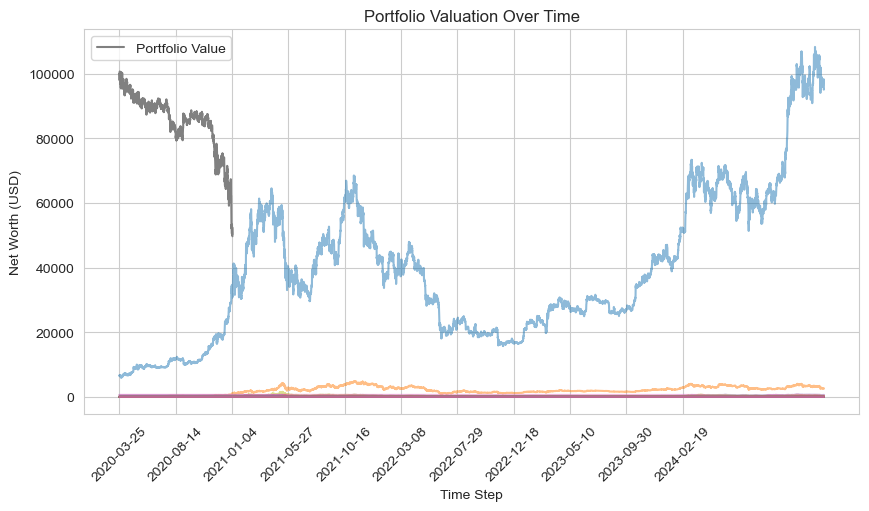

Step: 1724, Net Worth: 49685.6825018592
{'POLUSDT': -22, 'RENDERUSDT': -28705, 'BTCUSDT': -3053, 'SOLUSDT': -53, 'DOTUSDT': -4015, 'XLMUSDT': -2700, 'ETHUSDT': -56, 'DOGEUSDT': -46, 'SHIBUSDT': -25, 'ICPUSDT': -558, 'APTUSDT': -19001, 'TONUSDT': -240, 'ADAUSDT': -1990, 'XRPUSDT': 0, 'ETCUSDT': 0, 'OMUSDT': -8495, 'PEPEUSDT': -34, 'LTCUSDT': -59, 'ARBUSDT': -170, 'LINKUSDT': -1030, 'HBARUSDT': -12, 'AVAXUSDT': -27, 'AAVEUSDT': -997, 'ALGOUSDT': -48, 'TRXUSDT': 0, 'TAOUSDT': -35, 'VETUSDT': 0, 'TRUMPUSDT': 0, 'SUIUSDT': -41, 'FILUSDT': -27, 'BCHUSDT': -69, 'FDUSDUSDT': -1180, 'JUPUSDT': 0, 'BNBUSDT': -38, 'UNIUSDT': 0, 'NEARUSDT': 0, 'USDCUSDT': 0}


In [96]:
#Environment test random actions
env = CryptoTradingEnv(train_data)
obs = env.reset()
while True:
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    
    if done:
        break


scale=0.0125 # buy/sell signals on 1.25% of the token price data
env.render()
env.close()

In [88]:
env.crypto_held

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]])

PPO Trading-Bot

In [ ]:
import shutil

# Create the environment
train_env = CryptoTradingEnv(train_data)
def create_env():
    return train_env

train_env = make_vec_env(lambda: train_env, n_envs=1)

# log directory and delete older tensorboard logs
log_path = 'Train_tests\ Logs'
if os.path.exists(log_path):
    shutil.rmtree(log_path)

# Callbacks
# eval_callback = EvalCallback(env, best_model_save_path='Train_tests\ Models\ best_model_eval_callback',
#                             log_path='Train_tests\ Eval_Logs', eval_freq=1000,
#                             deterministic=True, render=False)

# Policy network architecture
# policy_kwargs = dict(net_arch = dict(pi = [256, 256], vf = [256, 256]))

# Find the optimal batch size
for n in range(1500,500,-1):
    if len(train_data) % n == 0:
        batch_size = n
        break

# Initialize the PPO agent
PPO_train = PPO(
                'MlpPolicy', 
                env= train_env, 
                n_steps = batch_size*5, 
                verbose = 1, 
                tensorboard_log = log_path,
                batch_size = batch_size,
                # policy_kwargs = policy_kwargs,
                # gae_lambda= 0.95,
                # gamma = 0.99,
                learning_rate=0.00005,
)

# Train the agent
time_steps = len(train_data)*50
PPO_train.learn(total_timesteps=time_steps)

# Save the model
PPO_model_path = 'Train_tests\ Models\ PPO_model_trading_bot.zip'

PPO_train.save(PPO_model_path)



Using cpu device
Logging to Train_tests\ Logs\PPO_1


KeyboardInterrupt: 

In [ ]:
evaluate_policy(PPO_train, env=train_env, n_eval_episodes=10)

(266.0, 0.0)

In [ ]:
print(step())

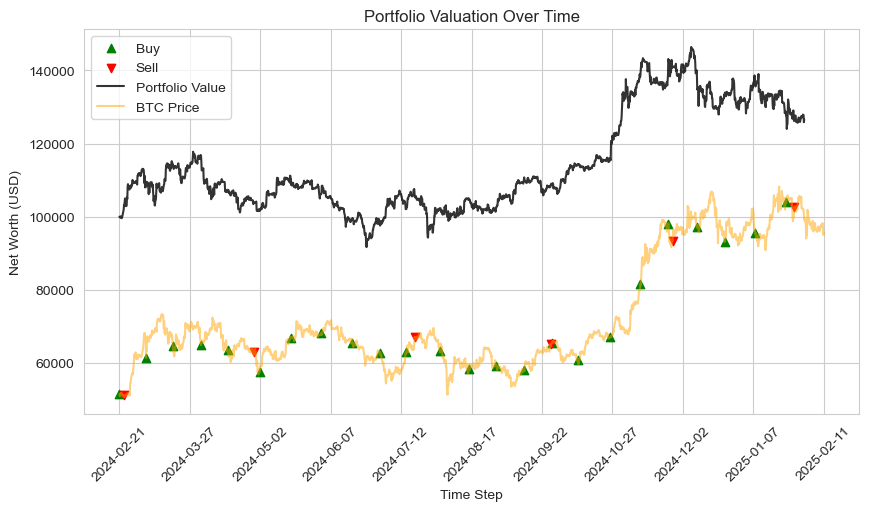

Step: 2081, Net Worth: 126572.40000000014
Final Net Worth: 126572.40000000014


In [ ]:
# Load the trained model
model = PPO.load(PPO_model_path)

# Create the test environment
test_env = CryptoTradingEnv(test_data)

# Test the agent
obs = test_env.reset()[0]
done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, _, info = test_env.step(action)

scale=0.025 # signals on 2.5% of the data
test_env.render()

print(f"Final Net Worth: {test_env.net_worth}")

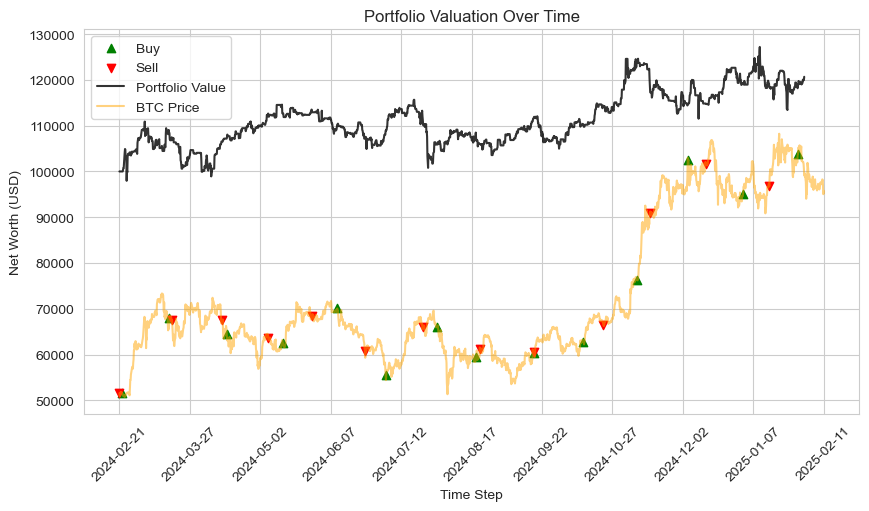

Step: 2081, Net Worth: 120678.96000000022


In [ ]:
#Random positions on unseen data
env = CryptoTradingEnv(test_data)
obs = env.reset()
while True:
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    
    if done:
        break
scale=0.025 # buy/sell signals on 2.5% of the token price data
env.render()
env.close()

In [ ]:
gym.envs.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v3', 'LunarLanderContinuous-v3', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v3', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Reacher-v5', 'Pusher-v2', 'Pusher-v4', 'Pusher-v5', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedPendulum-v5', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedDoublePendulum-v5', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'HalfCheetah-v5', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Hopper-v5', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Swimmer-v5', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Walker2d-v5', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'Humanoid-v5

In [ ]:
df_at = train_data.rename(columns={'BTCUSDT_Close':'Close','BTCUSDT_Volume':'Volume'})

In [ ]:
# environment with gym-anytrading
gym_at_env = gym.make('stocks-v0', df=df_at, frame_bound=(12,20000), window_size=12)


In [ ]:
gym_at_env.action_space


Discrete(2)

In [ ]:
gym_at_env.observation_space

Box(-10000000000.0, 10000000000.0, (12, 2), float32)

Episode finished. Resetting environment.


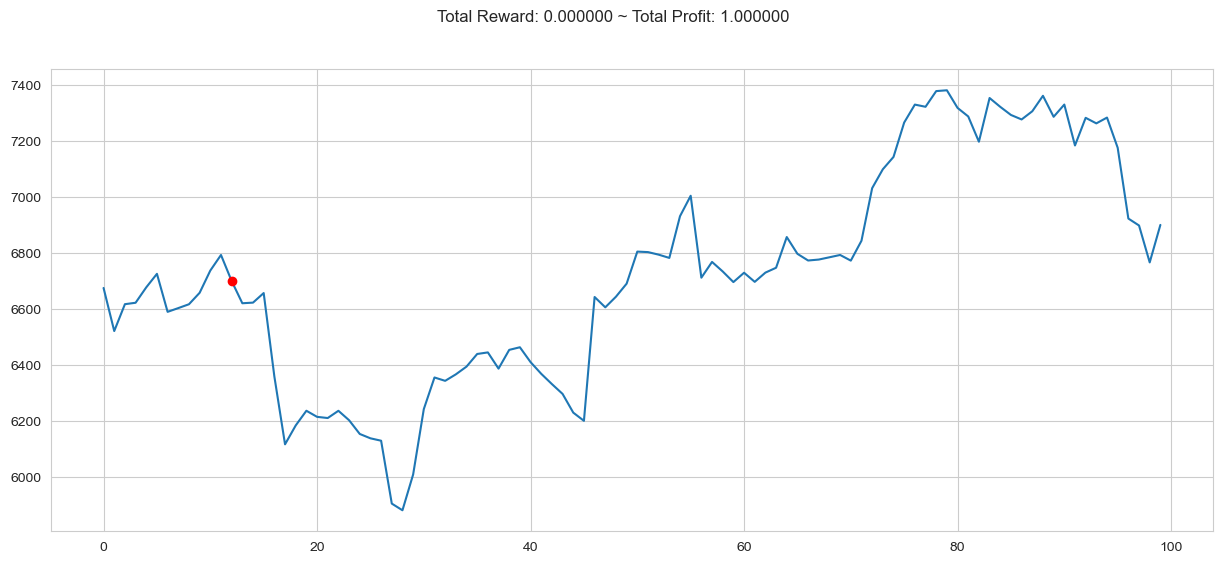

In [ ]:
gym_at_env.reset(seed=None)
while True:
    action = gym_at_env.action_space.sample()
    obs, reward, done, truncated, info = gym_at_env.step(action)

    if done or truncated:
        print("Episode finished. Resetting environment.")
        obs = gym_at_env.reset()
        break
plt.figure(figsize=(15,6))
plt.cla()  
gym_at_env.unwrapped.render_all()
plt.show()
gym_at_env.close()

In [ ]:
df_trade_env = train_data.rename(columns={'BTCUSDT_Close':'close','BTCUSDT_Volume':'volume'})

In [ ]:
gym_trade_env = gym.make('TradingEnv', df=df_trade_env, portfolio_initial_value = 100000, positions=[0,1,2], windows=12)

In [ ]:
gym_trade_env.action_space


Discrete(3)

In [ ]:
gym_at_env.observation_space

Box(-10000000000.0, 10000000000.0, (12, 2), float32)

Market Return : 665.52%   |   Portfolio Return : 78.89%   |   
Episode finished. Resetting environment.


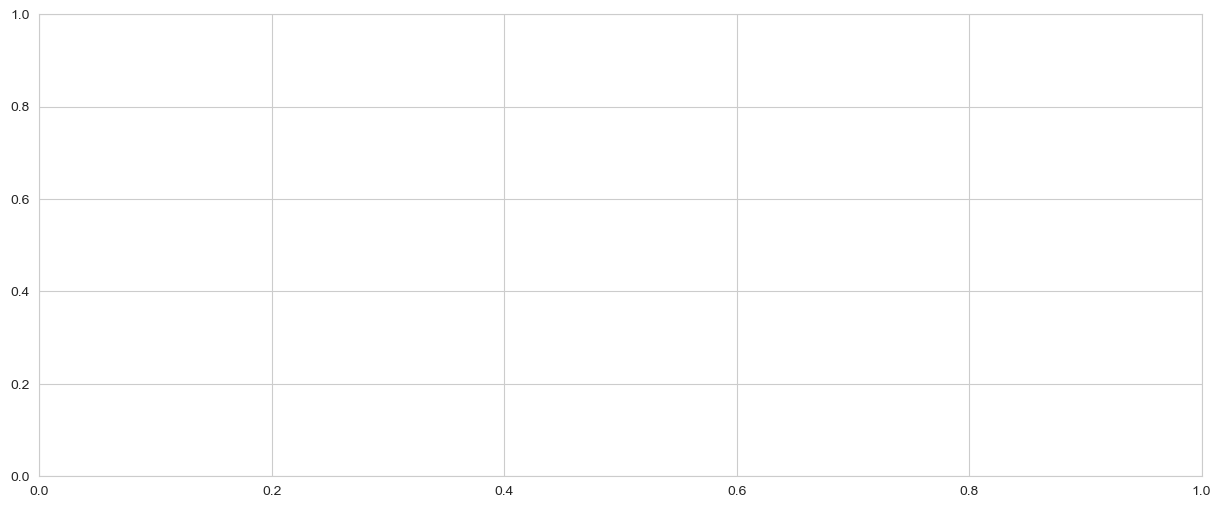

In [ ]:
gym_trade_env.reset(seed=None)
while True:
    action = gym_trade_env.action_space.sample()
    obs, reward, done, truncated, info = gym_trade_env.step(action)

    if done or truncated:
        print("Episode finished. Resetting environment.")
        obs = gym_trade_env.reset()
        break
plt.figure(figsize=(15,6))
plt.cla()  
gym_trade_env.render()
plt.show()
gym_trade_env.close()